# Code for generating plots in paper

In [ ]:
%matplotlib inline
import matplotlib

In [ ]:
import csv
import numpy as np
import pandas as pd
matplotlib.style.use('seaborn')
import seaborn as sns
sns.color_palette("Paired")
import matplotlib.pyplot as plt
from copy import deepcopy
import mpl_toolkits.axisartist as AA
from mpl_toolkits.axes_grid1 import host_subplot
from os import makedirs, listdir,system, chdir
from os.path import isfile, join

## Code for generating figure 3

In [1]:
def get_lattice(path):
    f = open(path,'r')
    lines = f.readlines()
    matrix = lines[2:5]
    matrix = [i.split() for i in matrix ]
    matrix = [[float(i) for i in j]for j in matrix]
    return matrix
def get_id(path):
    return niggli_lat_id.niggli_id(np.transpose(get_lattice(path)))[1] 
def get_structure(path):
    return niggli_lat_id.niggli_id(np.transpose(get_lattice(path))) 

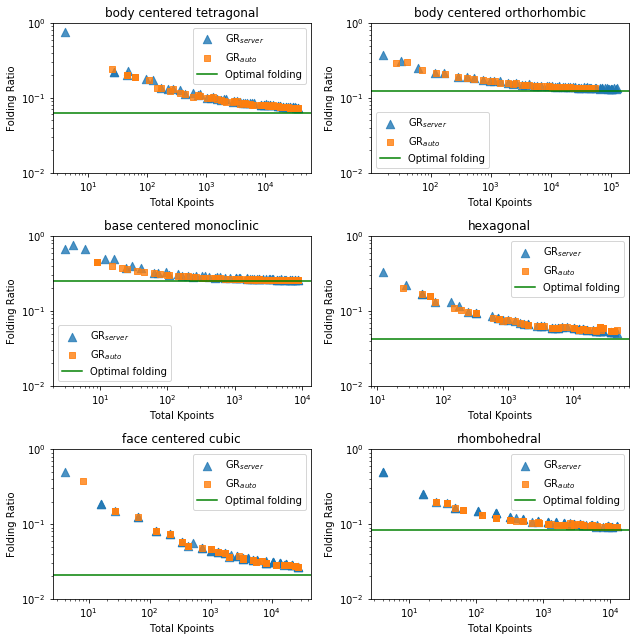

In [11]:
GR_Auto_Directory = "../data/GR_auto/"
GR_Server_Directory = "../data/GR_server/"
structures = ["Niggli_18","Niggli_19","K_9_orig","Ti_1_orig","Cr_Ni","K_7_orig"]
crystalline_type = ["body centered tetragonal", "body centered orthorhombic",
                 "base centered monoclinic", "hexagonal","face centered cubic","rhombohedral"]
fig = plt.figure()

n = 0
for e in structures:
    opt = float(open(GR_Auto_Directory + e + "/" + e + "_5/OPT",'r').readline())
    auto_data_directory = GR_Auto_Directory + e + "/" + e + '_'
    server_directory = GR_Server_Directory + e + "/" + e + '_'
    
    #Read  in data from GR_server 
    server_ratio_list = []
    server_total_list = []
    server_reduced_list = []
    for i in range(5,120,2):
        case = server_directory + str(i);
        f = open(case + "/KPOINTS","r")
        line = f.readline()

        server_total_list.append(int(line.split()[6]))
        server_reduced_list.append(int(line.split()[10]))
        server_ratio_list.append(float(server_reduced_list[-1])/float(server_total_list[-1]))

        f.close()
            
    #Read in data from GR_auto
    auto_ratio_list = []
    auto_total_list = []
    auto_reduced_list = []
    
    for i in range(5,120,2):
        case = auto_data_directory + str(i);
        if isfile(case + "/KPOINTS"):
            f = open(case + "/KPOINTS","r")
            line = f.readline()
            #print e,str(i)
            frac = line.split()[9:]
            if len(frac) == 1:
                r_points = int(frac[0].split('/')[0])
                t_points = int(frac[0].split('/')[1])
            else:
                r_points = int(frac[0][:-1])
                t_points = int(frac[1])
                
            auto_total_list.append(t_points)
            auto_reduced_list.append(r_points)
            auto_ratio_list.append((float(r_points)/float(t_points)))

            f.close()
    
    #Plotting figure / Configuring subplots
    plt.subplot(3, 2, n+1)
    plt.tight_layout()
    opt_line = plt.axhline(y=opt, xmin=0.0, xmax=1.0,color = 'g')
    server = plt.scatter(server_total_list,server_ratio_list,marker = "^",alpha = .8,s = 70)
    auto = plt.scatter(auto_total_list,auto_ratio_list,marker = 's',alpha = .8)
    
    l = plt.gca().figure.subplotpars.left
    r = plt.gca().figure.subplotpars.right
    t = plt.gca().figure.subplotpars.top
    b = plt.gca().figure.subplotpars.bottom
    figw = float(8)/(r-l)
    figh = float(8)/(t-b)
    plt.gca().figure.set_size_inches(figw, figh)
    
    plt.title(crystalline_type[n])
    plt.ylabel('Folding Ratio')
    plt.xlabel('Total Kpoints')
    plt.ylim(0.01,1)
    
    plt.gca().set_yscale('log')
    plt.gca().set_xscale('log')

    plt.legend([server,auto,opt_line], ["GR$_{server}$","GR$_{auto}$","Optimal folding"]) 
    
    n+=1
    
fig.savefig("../plots/ratio_compare.pdf", bbox_inches='tight')
plt.show()


## Code for generating figure 4

In [ ]:
cubic = ["W","V","K","Al","Cu","Pd"]
hcp = ["Ti","Re","Y"]
metals = cubic+hcp

In [ ]:
def make_scatter_plot_data(data_frame):
    """Converts the data in the dataframe from it's read in format 
    to the format needed for plotting. Which entails dropping the 
    `mean` and `count` columns from the data."""
    rows = np.asarray(data_frame.index)
    
    data = []
    for row in rows:
        temp = data_frame.ix[:,data_frame.columns.difference(["mean","count"])].loc[row].dropna().values
        for t in temp:
            data.append([float(row),t])
            
    return np.array(data)
        

### Figure 4

In [ ]:
def get_mean_data_kpd(method, elements, cell_sizes=None):
    """Gathers the convergence data for the given method and places it
    in a pandas dataframe where each column is a different cell 
    size and each row is a different k-point density. The dataframe also
    contains the mean error per density and numbder of times 
    the density occures.
    
    Args:
        method (str): "GR_auto", "GR_server", or "MP"
        elements (list of str): A list consisting of the desired 
            elements ("V", "W", "Cu", "Al", "K", "Pd", "Ti", "Y", "Re")
        sub_method (str, optional): The sampling scheme for the 
            Froyen method ("sc", "bcc", "fcc", "hcp"). A sub_method is
            required for the Froyen method and for any other method
            this should be None.
        cell_sizes (list, optional): The list of cell sizes to include in the
            plot.
    
    Returns:
        outdf (pandas.dataframe): A pandas dataframe of the error in
            the calculated energy at each density (row) and supercell 
            (column) in addition to a column of the average error per
            density.
    """
    for el in elements: # loop over element types
        if el in ["Ti","Y","Re"]:
            if cell_sizes is None:
                sizes = range(1,8)
            else:
                sizes = cell_sizes
        else:
            if cell_sizes is None:
                sizes = range(1,12)
            else:
                sizes = cell_sizes
        
        for i in sizes: # loop over element sizes
            data = []
            kpd = []
            # read the file
            f = open("../data/{0}/{1}_conv/{2}_atom_kpd_conv.csv".format(method,el,i),"r")
            reader = csv.reader(f,delimiter='\t')
            # parse the file for the data, if this k-point density has occured before 
            # then we take the average of the errors reported (this is rare), otherwise
            # we just add it to the dataframe.
            for row in reader:
                # if the system is hcp we need to divide the answeres by 2
                # in order to get error per atom instead of error per cell.
                if el in ["Ti","Re","Y"]:
                    if float(row[0]) in kpd and float(row[1]) >= 1E-6:
                        loc = kpd.index(float(row[0]))
                        data[loc][1] = (data[loc][1]+(float(row[1])/2.))/2.
                    elif float(row[1]) >= 1E-6:
                        kpd.append(float(row[0]))
                        point = [float(row[0]),float(row[1])/2.]
                        data.append(point)                    
                else:
                    if float(row[0]) in kpd and float(row[1]) >= 1E-6:
                        loc = kpd.index(float(row[0]))
                        data[loc][1] = (data[loc][1]+float(row[1]))/2.
                    elif float(row[1]) >= 1E-6:
                        kpd.append(float(row[0]))
                        point = [float(row[0]),float(row[1])]
                        data.append(point)
                    
            data = np.array(data)
            if len(data) >= 1:
                df = pd.DataFrame(data[:,1:],index=data[:,0])#,columns=[str(i)+' atom'])    
            else:
                # If there was no usable data for an element size print a warning
                print("Method: {0}, element: {1}, size: {2} had no useable "
                      "data".format(method,el,i))
                
            # if the dataframe already exists then add to it, otherwise save the dataframe.
            if i > 1 or el != elements[0]:
                outdf = pd.concat([outdf,df], axis=1)
            else:
                outdf = df

    # find the mean and number of instances for each row. (across element types and cell sizes)
    outdf['mean'] = outdf.mean(axis=1) 
    outdf['count'] = outdf.apply(lambda x: x.count(), axis=1)
    return outdf

In [ ]:
# get the data
GR_server_metals = get_mean_data_kpd("GR_server", metals)
MP_metals = get_mean_data_kpd("MP", metals)
GR_auto_metals = get_mean_data_kpd("GR_auto",metals)

In [ ]:
len(GR_auto_metals)+len(MP_metals)+len(GR_server_metals)

In [ ]:
# convert the data to the plotting format
GR_server_metals_scat = make_scatter_plot_data(GR_server_metals)
MP_metals_scat = make_scatter_plot_data(MP_metals)
GR_auto_metals_scat = make_scatter_plot_data(GR_auto_metals)

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
 
ax1.scatter(GR_server_metals_scat[:,0],abs(GR_server_metals_scat[:,1]),
            label="Generalized Regular Server ($GR_{server}$)",marker="o",s=3,c='b')
ax1.scatter(GR_auto_metals_scat[:,0],abs(GR_auto_metals_scat[:,1]),
            label="Generalized Regular Automatic ($GR_{auto}$)",marker="+",s=3,c='g')
ax1.scatter(MP_metals_scat[:,0],abs(MP_metals_scat[:,1]),
            label="Monkhorst-Pack (MP)",marker="s",s=3,c='r')

ax1.set_xlabel("Number of $k$-points / $\mathrm{\AA}^{-3}$",fontsize=22)
ax1.set_xscale('log')
new_tick_locations = np.array([.1,1,10,100,1000,10000,100000])
ax1.set_xlim(.1,100000)
ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(new_tick_locations)
ax2.set_xlabel("$(2\pi)\mathrm{\AA}^{-1}$ / (Number of $k$-points$)^{1/3}$",
               fontsize=22)
ax2.set_xscale('log')
ax2.set_xticklabels(["1.00","$2.154$","$1$","$0.464$",
                    "$0.215$","$0.1$","$0.046$","$0.021$"],fontsize=18)
ax2.grid(False)

ax1.set_ylabel("Total energy error (eV)",fontsize=22)
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(18) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(18) 

plt.yscale('log')
plt.ylim(1E-6,9E0)
plt.xlim(1E-1,1E5)
ax1.legend(markerscale=2,fontsize=14)
plt.savefig("../plots/All_methods_KPD_2.pdf",bbox_inches="tight")
plt.show()

### Figure 5

This plot requires output from an R script held in this directory loess.R. The output data from this script has already been saved to `data/R_workspace/` but if you want to regenerate that ouput you will need to use the R script.

In [ ]:
def get_mean_data_ibzkpd(method,elements):
    """Gathers the convergence data for the given method and places it
    in a pandas dataframe where each column is a different cell 
    size and each row is a different irreducible k-point density. 
    The dataframe also contains the mean error per density and
    numbder of times the density occures.
    
    Args:
        method (str): "GR_auto", "GR_server", or "MP"
        elements (list of str): A list consisting of the desired 
            elements ("V", "W", "Cu", "Al", "K", "Pd", "Ti", "Y", "Re")
        sub_method (str, optional): The sampling scheme for the 
            Froyen method ("sc", "bcc", "fcc", "hcp"). A sub_method is
            required for the Froyen method and for any other method
            this should be None.
    
    Returns:
        outdf (pandas.dataframe): A pandas dataframe of the error in
            the calculated energy at each density (row) and supercell 
            (column) in addition to a column of the average error per
            density.
    """
    for el in elements: # loop over the elements
        if el in ["Ti","Y","Re"]:
            sizes = range(1,8)
        else:
            sizes = range(1,12)
            
        for i in sizes: # loop over the cell sizes
            data = []
            kpd = []
            # read the correct file
            f = open("../data/{0}/{1}_conv/{2}_atom_IBZKPTS_dese_conv.csv".format(method,el,i),"r")
            reader = csv.reader(f,delimiter='\t')
            # parse the file for the data, if this k-point density has occured before 
            # then we take the average of the errors reported (this is rare), otherwise
            # we just add it to the dataframe.
            for row in reader:
                # if the system is hcp we need to divide the answeres by 2
                # in order to get error per atom instead of error per cell.
                if el in ["Ti","Re","Y"]:
                    if float(row[0]) in kpd and float(row[1]) >= 1E-6:
                        loc = kpd.index(float(row[0]))
                        data[loc][1] = (data[loc][1]+(float(row[1])/2.))/2.
                    elif float(row[1]) >= 1E-6:
                        kpd.append(float(row[0]))
                        point = [float(row[0]),float(row[1])/2.]
                        data.append(point)                    
                else:
                    if float(row[0]) in kpd and float(row[1]) >= 1E-6:
                        loc = kpd.index(float(row[0]))
                        data[loc][1] = (data[loc][1]+float(row[1]))/2.
                    elif float(row[1]) >= 1E-6:
                        kpd.append(float(row[0]))
                        point = [float(row[0]),float(row[1])]
                        data.append(point)
                    
            data = np.array(data)
            # If there was no useable data warn the user.
            if len(data) >= 1:
                df = pd.DataFrame(data[:,1:],index=data[:,0])
            else:
                print("Method: {0}, element: {1}, size: {2}".format(method,el,i))
                
            # if the dataframe already exists add to it, otherwise just save it
            if i > 1 or el != elements[0]:
                outdf = pd.concat([outdf,df], axis=1)
            else:
                outdf = df
    # store the mean and count of the kpd instances across elemnts and sizes
    outdf['mean'] = outdf.mean(axis=1) 
    outdf['count'] = outdf.apply(lambda x: x.count(), axis=1)
    return outdf

In [ ]:
# Get the raw data from the files
GR_server_metals_ibz = get_mean_data_ibzkpd("GR_server", metals)
MP_metals_ibz = get_mean_data_ibzkpd("MP", metals)
GR_auto_metals_ibz = get_mean_data_ibzkpd("GR_auto", metals)

In [ ]:
# convert the data to the format needed for plotting
GR_server_metals_scat_ibz = make_scatter_plot_data(GR_server_metals_ibz)
MP_metals_scat_ibz = make_scatter_plot_data(MP_metals_ibz)
GR_auto_metals_scat_ibz = make_scatter_plot_data(GR_auto_metals_ibz)

In [ ]:
# Save the data to the R_workspace so that the loess smoothing can run on them.
np.savetxt("../data/R_workspace/GR_server_irkpd.csv",GR_server_metals_scat_ibz,delimiter="\t")
np.savetxt("../data/R_workspace/MP_irkpd.csv",MP_metals_scat_ibz,delimiter="\t")
np.savetxt("../data/R_workspace/GR_auto_irkpd.csv",GR_auto_metals_scat_ibz,delimiter="\t")

In [ ]:
# Read in the loess fit
GR_server_irkpd_loess = 10**np.genfromtxt("../data/R_workspace/GR_server_irkpd_loess.csv",delimiter=",")[1:]
MP_irkpd_loess = 10**np.genfromtxt("../data/R_workspace/MP_irkpd_loess.csv",delimiter=",")[1:]
GR_auto_irkpd_loess = 10**np.genfromtxt("../data/R_workspace/GR_auto_irkpd_loess.csv",delimiter=",")[1:]

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
#ax2 = ax1.twiny()
 
ax1.scatter(GR_server_metals_scat_ibz[:,0],abs(GR_server_metals_scat_ibz[:,1]),
            label="Generalized Regular Server ($GR_{server}$)",marker="o",s=3,c='b')
ax1.scatter(GR_auto_metals_scat_ibz[:,0],abs(GR_auto_metals_scat_ibz[:,1]),
            label="Generalized Regular Automatic ($GR_{auto}$)",marker="+",s=3,c='g')
ax1.scatter(MP_metals_scat_ibz[:,0],abs(MP_metals_scat_ibz[:,1]),
            label="Monkhorst-Pack (MP)",marker="s",s=3,c='r')

ax1.plot(GR_server_irkpd_loess[:,0],GR_server_irkpd_loess[:,1],label="$GR_{server}$ Loess",c="#000080")
ax1.plot(MP_irkpd_loess[:,0],MP_irkpd_loess[:,1],label="MP Loess",c="#800000")
ax1.plot(GR_auto_irkpd_loess[:,0],GR_auto_irkpd_loess[:,1],label="$GR_{auto}$ Loess",c="#00FF00")
ax1.set_xlabel("Number of irreducible $k$-points / $\mathrm{\AA}^{-3}$",
               fontsize=22)
ax1.set_xscale('log')

new_tick_locations = np.array([.1,1,10,100,1000,10000,100000])
ax1.set_xlim(.1,100000)
#ax2.set_xlim(ax1.get_xlim())
#ax2.set_xticks(new_tick_locations)
#ax2.set_xlabel("$\mathrm{\AA}^{-1}$ / (Number of $k$-points$)^{1/3}$",
#              fontsize=22)
#ax2.set_xscale('log')
#ax2.set_xticklabels(["1.00","$2.154$","$1$","$0.464$",
#                    "$0.215$","$0.1$","$0.046$","$0.021$"],fontsize=18)
#ax2.grid(False)

ax1.set_ylabel("Total energy error (eV/atom)",fontsize=22)
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(18) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(18) 
plt.yscale('log')
plt.ylim(1E-6,9E0)
plt.xlim(1E-1,1E5)

handles,labels = ax1.get_legend_handles_labels()
handles = [handles[3],handles[4],handles[5],handles[0],handles[1],handles[2]]
labels = [labels[3],labels[4],labels[5],labels[0],labels[1],labels[2]]
ax1.legend(handles, labels, markerscale=2,fontsize=13)

plt.savefig("../plots/All_methods_IRKPD.pdf",bbox_inches="tight")
plt.show()

## Make Figure 6

This plot requires output from an R script held in this directory loess.R. The output data from this script has already been saved to data/R_workspace/ but if you want to regenerate that ouput you will need to use the R script.

In [ ]:
def interpolate(p1,p2,y):
    """Intepolates the line between two points.
    
    Args:
        p1 (list): [x,y]
        p2 (list): [x,y]
        
    Returns:
        interpolated x value.
    """
    
    slope = (p2[1]-p1[1])/(p2[0]-p1[0])
    return p2[0]+(y-min(p2[1],p1[1]))/slope

In [ ]:
def make_ratios(top,bottom):
    """Makes the ratio of the top vs the bottom methods 
    of grid generation in DFT in terms of the irreducible
    k-point density of top/irreducible k-point density of bottom
    at a given error value.
    
    top (list): the irreducible k-point densities and errors for 
        the top method.
        
    bottom (list): the irreducible k-point densities and errors for 
        the top method.
        
    Returns:
        numpy.array of the erros and ratios [error,ratio].
    """
    ratio = []
    count = 0
    for ti in top:
        t_dens = ti[0]
        t_err = ti[1]
        found = False
        for j in range(len(bottom)):
            bi = bottom[j]
            if bi[1] < t_err:
                found = True 
                b_dens = interpolate(bottom[j-1],bi,t_err)
                break 
        if found == True:
            ratio.append([t_err,t_dens/b_dens])
            
    return np.array(ratio)

In [ ]:
# get the data and make the take the ratios of the methods
GR_server_irkpd_loess = 10**np.genfromtxt("../data/R_workspace/GR_server_irkpd_loess.csv",delimiter=",")[1:]
MP_irkpd_loess = 10**np.genfromtxt("../data/R_workspace/MP_irkpd_loess.csv",delimiter=",")[1:]
GR_auto_irkpd_loess = 10**np.genfromtxt("../data/R_workspace/GR_auto_irkpd_loess.csv",delimiter=",")[1:]

MP_GR_server = make_ratios(MP_irkpd_loess,GR_server_irkpd_loess)
GR_auto_GR_server = make_ratios(GR_auto_irkpd_loess,GR_server_irkpd_loess)

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.axhline(1,c="k",linewidth=1)
ax1.axvline(1E-3,ls='dotted',c='k',linewidth=1)
ax1.plot(MP_GR_server[:,0],1/MP_GR_server[:,1],label="Monkhorst-Pack (MP)",linewidth=3,c='r')#,ls='--')
ax1.plot(GR_auto_GR_server[:,0],1/GR_auto_GR_server[:,1],label="Automatic GR ($GR_{auto})$",linewidth=3,c='g')#,ls='--')


ax1.set_yscale("log")
ax1.set_xlabel("Total Energy Error (eV/atom)",fontsize=22)
ax1.set_ylabel("Relative Efficiency",fontsize=22)
ax1.yaxis.grid(True,which="minor")
plt.yscale("log")
plt.loglog()

plt.xlim(7E-5,8E-2)
plt.ylim(9E-2,3E0)
plt.legend(fontsize=14)

plt.savefig("../plots/Relative_efficiency.pdf",bbox_inches="tight")
plt.show()